In [1]:
import pandas as pd

In [ ]:
ads_data = pd.read_csv(r"C:\Users\user\Desktop\ads\ads_data.csv")
ads_client = pd.read_csv(r"C:\Users\user\Desktop\ads\ads_clients_data.csv") #Чтение датафрэймов

In [3]:
ads_data.head() 

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [4]:
ads_event =  ads_data.groupby(['ad_id', 'event'], as_index = False).agg({'time':'count'}).rename(columns={'time':'event_number'})
#Группировка по id объявления и событию, подсчёт количества определённого типа событий по каждому объявлению

In [5]:
ads_event_pivot = ads_event.pivot(index = 'ad_id', columns= 'event', values='event_number').fillna(0) 
#Изменение структуры таблицы, с заменой пропущенных значений на 0

In [6]:
ads_event_pivot.mean().round() #Расчёт среднего для каждого события

event
click    113.0
view     923.0
dtype: float64

In [7]:
ads_view = ads_event.query('event == "view"') #Создание датафрэйма только с просмотрами объявлений

In [8]:
import seaborn as sns
import numpy as np

<Axes: xlabel='event_number', ylabel='Count'>

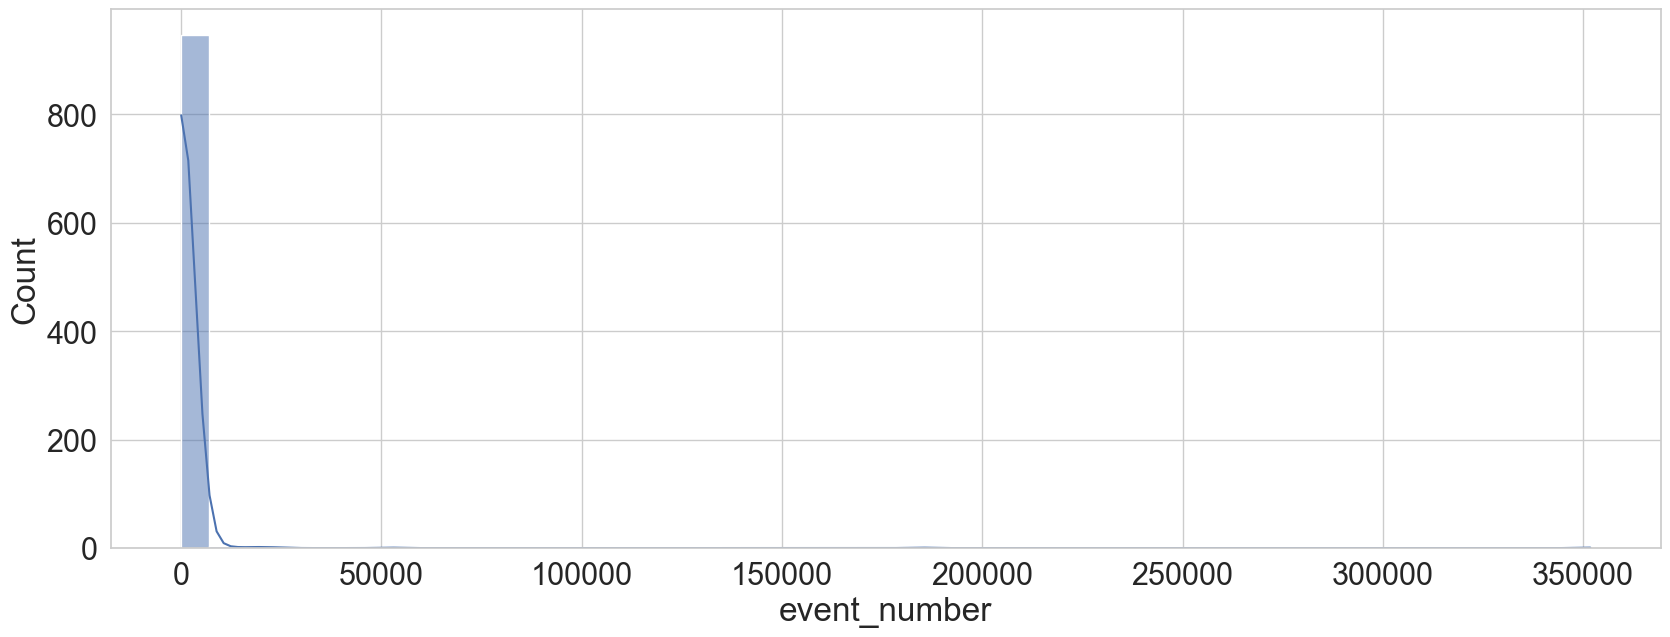

In [39]:
sns.histplot(ads_view.event_number, kde = True, bins = 50) #Построение распределения просмотров по количеству просмотров

In [ ]:
ads_view['event_number_log'] = np.log(ads_view['event_number']) #Логарифмирование количества просмотров для построения нового распределения

C:\Users\user\AppData\Local\Temp\ipykernel_17376\457510012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ads_view['event_number_log'] = np.log(ads_view['event_number'])


In [11]:
sns.set(font_scale= 2, style = 'whitegrid', rc = {'figure.figsize':(20,7)})

<Axes: xlabel='event_number_log', ylabel='Count'>

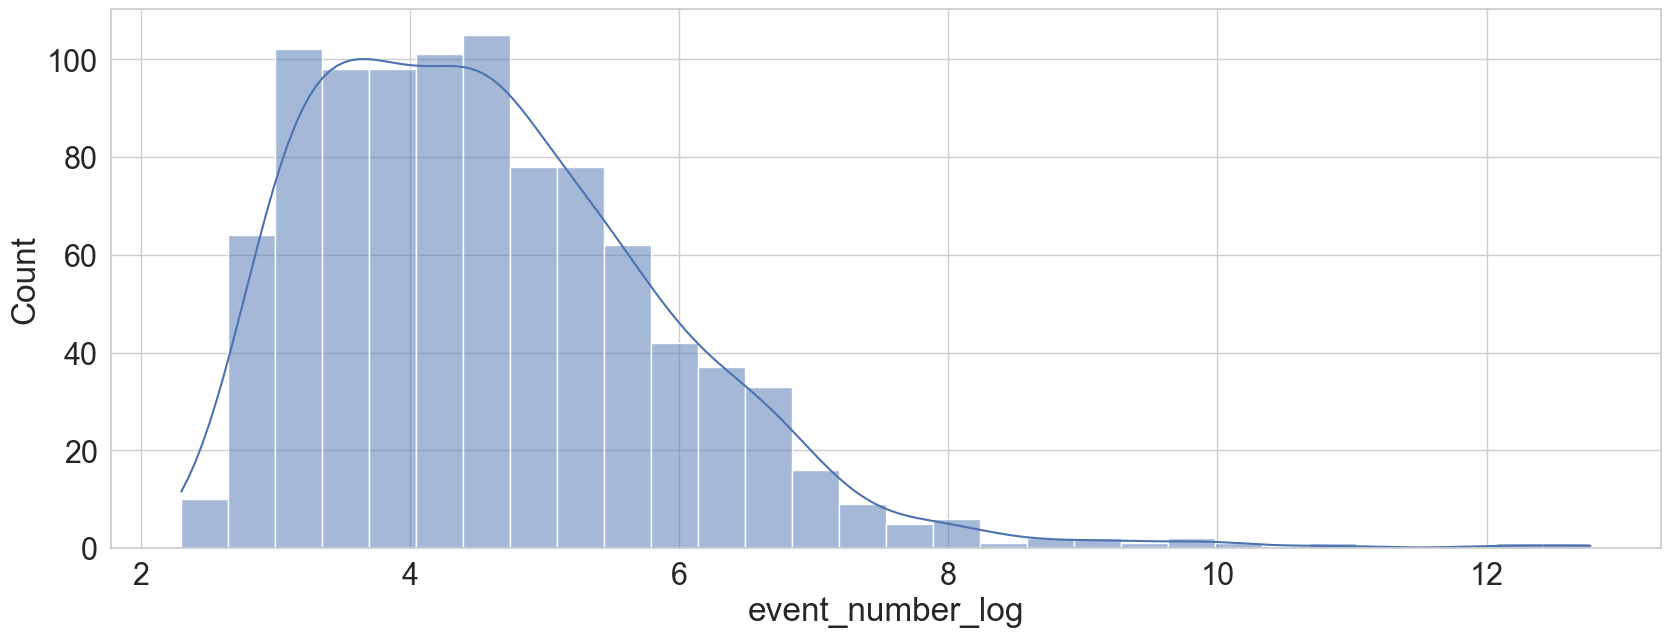

In [ ]:
sns.histplot(ads_view['event_number_log'], kde = True) #Построение распределения прологарифмированных данных

In [ ]:
 ads_per_date = ads_data.query('event =="view"').pivot_table(index = 'ad_id', columns = 'date', values = 'time', aggfunc = 'count')
#Агрегирование количества событий по объявлению и дате

In [ ]:
ads_per_date_mean = ads_per_date.mean() # Расчёт среднего 

In [ ]:
ads_per_date_mean_rol2 = ads_per_date_mean.rolling(2).mean().round() # Расчёт скользящего среднего с окном 2

<Axes: xlabel='date'>

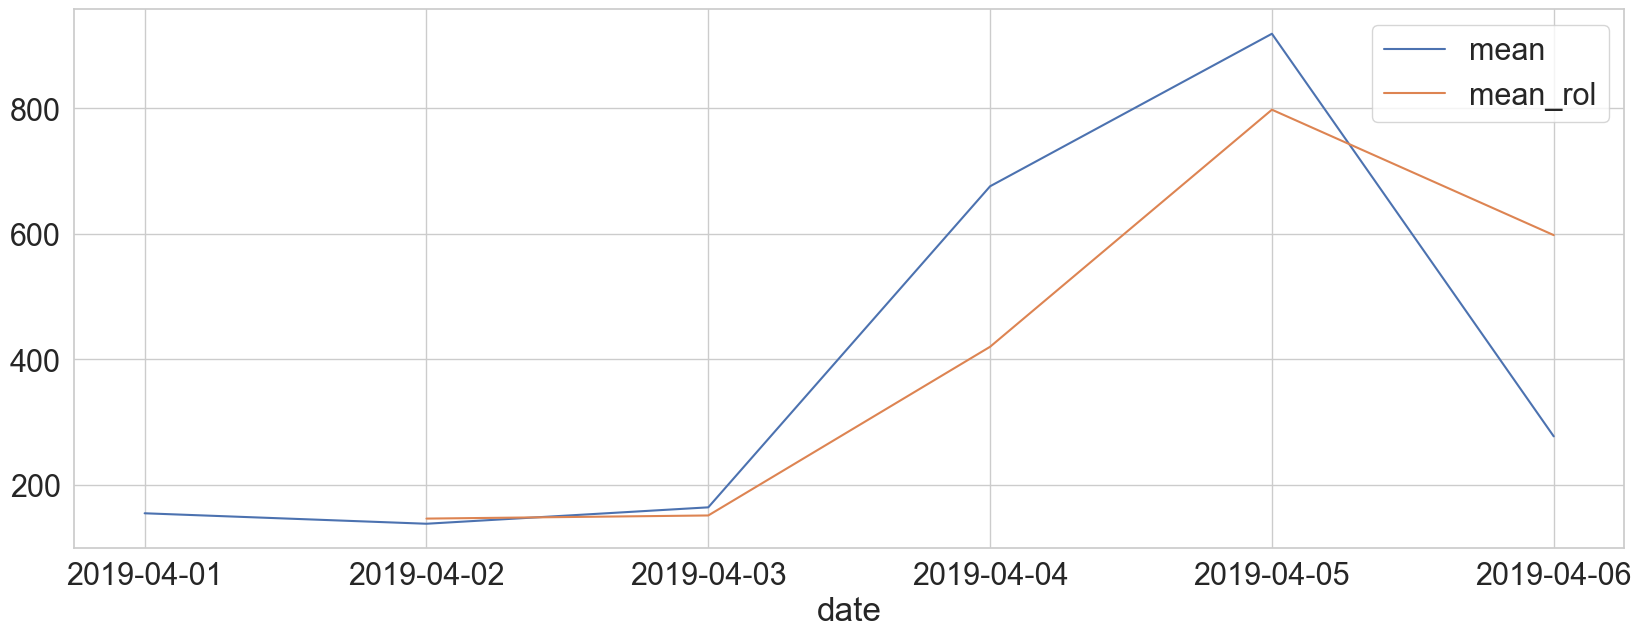

In [ ]:
sns.lineplot(ads_per_date_mean, label = 'mean')
sns.lineplot(ads_per_date_mean_rol2, label = 'mean_rol')#Построения граика сравнения среднего и скользящего среднего для поиска аномалий

In [ ]:
(ads_per_date_mean - ads_per_date_mean_rol2).abs().idxmax() #Поиск даты в которую отклонени было наибольшим

'2019-04-06'

In [ ]:
def ad_problem (data_base):
    ads_per_date_mean = data_base.mean()
    ads_per_date_mean_rol2 = ads_per_date_mean.rolling(2).mean().round()
    anomaly_date = (ads_per_date_mean - ads_per_date_mean_rol2).abs().idxmax()
    different_value = ads_per_date_mean.subtract(ads_per_date_mean_rol2)[anomaly_date]
    if different_value <= 0:
        ad_id = data_base[anomaly_date].idxmax()
    else:
        ad_id = data_base[anomaly_date].idxmin()
    return ad_id
#Написание программы для поиска id проблемного объявления
    



In [ ]:
ad_problem(ads_per_date) #Поиск проблемного объявления в нашем датафрэйме

np.int64(112583)

In [ ]:
ads_per_date.query('ad_id == 112583') #Просмотр количества событий с этим объявлением

date,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06
ad_id,,,,,,
112583,NaN,NaN,NaN,NaN,302811.0,48991.0


In [21]:
ads_client

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08
...,...,...,...,...
122073,2020-05-07,122074,-130470790,2018-12-21
122074,2020-05-07,122075,-130911261,2018-11-09
122075,2020-05-07,122076,-130494912,2018-10-27
122076,2020-05-07,122077,-130910585,2018-12-05


In [ ]:
data_full = ads_data.merge(ads_client.drop(columns=['date', 'community_id'])) 
#Объединение двух датафрэймов с базой данными клиентов и рекламными объявлениями

In [ ]:
data_full[['date', 'create_date']] = data_full[['date', 'create_date']].apply(pd.to_datetime) 
#Приведение столбцов с датой к необходимому типу данных 

In [ ]:
data_full.groupby('client_union_id').apply(lambda group: (group.date - group.create_date).min()).mean() 
#Поиск среднего времени между созданием аккаунта и первым заказом

C:\Users\user\AppData\Local\Temp\ipykernel_17376\2300229530.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_full.groupby('client_union_id').apply(lambda group: (group.date - group.create_date).min()).mean()


Timedelta('124 days 09:04:43.532219570')

In [25]:
deadline = pd.Timedelta(365, unit='d')

In [26]:
creation_difference = data_full.groupby('client_union_id').apply(lambda group: (group.date - group.create_date).min())

C:\Users\user\AppData\Local\Temp\ipykernel_17376\3335383289.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  creation_difference = data_full.groupby('client_union_id').apply(lambda group: (group.date - group.create_date).min())


In [27]:
 ads_client.client_union_id.nunique()

122078

In [ ]:
round(creation_difference.loc[creation_difference<deadline].shape[0] / ads_client.client_union_id.nunique() * 100, 2)
#Расчёт конверсии клиентов сроком до 1 года

0.69

In [29]:
bins = pd.to_timedelta([0, 30, 90, 180, 365], unit = 'd')

In [ ]:
pd.cut(creation_difference, bins = bins, labels = ['0-30', '30-90', '90-180', '180-365']).value_counts()
#Распределение времени первых заказов

90-180     396
30-90      263
180-365    168
0-30        11
Name: count, dtype: int64

In [31]:
import plotly.express as px

In [ ]:
px.bar(pd.cut(creation_difference, bins = bins, labels = ['0-30', '30-90', '90-180', '180-365']).value_counts())
#Построение гистограммы распределения

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=count<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'count',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'count',
              'orientation': 'v',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['90-180', '30-90', '180-365', '0-30'], dtype=object),
              'xaxis': 'x',
              'y': {'bdata': 'jAEHAagACwA=', 'dtype': 'i2'},
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'index'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'value'}}}
})